# Lab 4
* Paper: [On Spectral Clustering: Analysis and an algorithm](http://ai.stanford.edu/~ang/papers/nips01-spectral.pdf)

In [621]:
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
from scipy.linalg import sqrtm, eigh
import pandas as pd
import networkx as nx

# Warm-up

> **Lab description**:  As a warm-up task, you should first compute the eigenvectors and eigenvalues of a set of graphs and find out how many communities these graphs have. 


In [622]:
example1 = './data/example1.dat'
test = './data/test.dat'

Let's store the data in a Pandas DataFrame.

In [623]:
df = pd.read_csv(test)
df['weight'] = 1
df

,from,to,weight
0,1,2,1
1,1,3,1
2,2,1,1
3,2,3,1
4,2,4,1
5,3,1,1
6,3,2,1
7,4,2,1
8,4,5,1
9,4,6,1


As proposed in the Matlab Tutorial, we are extracting each column from the data file and storing it in a list. In this way, you can find indices and work with them as you would in Matlab.

In [624]:
col1, col2, _ = df.to_numpy().T
print(col1, col2)

[1 1 2 2 2 3 3 4 4 4 5 5 6 6] [2 3 1 3 4 1 2 2 5 6 4 6 4 5]


I think the example confuses `max_id` with a regular `max`; we are supposed to find the max value, and use it when we create a sparse matrix. I am not sure why, but I'll try that approach. We'll bypass the problem by using the Python librar `networkx` to create the graph.

In [625]:
G = nx.from_pandas_edgelist(df=df, source='from', target='to', edge_attr=['weight'])

In [626]:
G = nx.from_pandas_edgelist(df=df, source='from', target='to', edge_attr=['weight'])
points = nx.to_numpy_matrix(G)
pd.DataFrame(points, dtype=int)

,0,1,2,3,4,5
0,0,1,1,0,0,0
1,1,0,1,1,0,0
2,1,1,0,0,0,0
3,0,1,0,0,1,1
4,0,0,0,1,0,1
5,0,0,0,1,1,0


Now I use numpy to find the eigenvalues and eigenvectors of the sparse matrix.

`LA.eigh(A)` returns:

* `eigvals`: a 1D array of eigenvalues
* `eigvecs`: a 2D array of normalized (unit "length) eigenvectors


In [627]:
eigvals, eigvecs = LA.eigh(points)
print(pd.DataFrame(eigvals))
print(pd.DataFrame(eigvecs))

          0
0 -1.732051
1 -1.000000
2 -1.000000
3 -0.414214
4  1.732051
5  2.414214
          0             1             2         3         4         5
0 -0.229850  7.071068e-01  0.000000e+00 -0.353553 -0.444037  0.353553
1  0.627963 -3.330669e-16 -5.680648e-17  0.500000 -0.325058  0.500000
2 -0.229850 -7.071068e-01  5.680648e-17 -0.353553 -0.444037  0.353553
3 -0.627963 -4.996004e-16  3.697785e-32  0.500000  0.325058  0.500000
4  0.229850  2.775558e-16 -7.071068e-01 -0.353553  0.444037  0.353553
5  0.229850  2.775558e-16  7.071068e-01 -0.353553  0.444037  0.353553


Not sure this is right, but let's try to just sort it straight away.

In [628]:
pd.DataFrame(np.sort(eigvecs))

,0,1,2,3,4,5
0,-0.444037,-3.535534e-01,-2.298504e-01,0.000000,3.535534e-01,0.707107
1,-0.325058,-3.330669e-16,-5.680648e-17,0.500000,5.000000e-01,0.627963
2,-0.707107,-4.440369e-01,-3.535534e-01,-0.229850,5.680648e-17,0.353553
3,-0.627963,-4.996004e-16,3.697785e-32,0.325058,5.000000e-01,0.500000
4,-0.707107,-3.535534e-01,2.775558e-16,0.229850,3.535534e-01,0.444037
5,-0.353553,2.775558e-16,2.298504e-01,0.353553,4.440369e-01,0.707107


That concludes the warmup, let's continue with the main task.

# Initial analysis

We are going to explore the two datasets by plotting them first.

## Read data and setup graphs

In [629]:
example1 = './data/example1.dat'
example2 = './data/example2.dat'

# appending a weight column
df_example1 = pd.read_csv(example1)
df_example1['weight'] = 1

# already has a weight column
df_example2 = pd.read_csv(example2)

# create a graph from the data
G_example1 = nx.from_pandas_edgelist(df=df_example1, source='from', target='to', edge_attr=['weight'])
G_example2 = nx.from_pandas_edgelist(df=df_example2, source='from', target='to', edge_attr=['weight'])

## Draw graphs

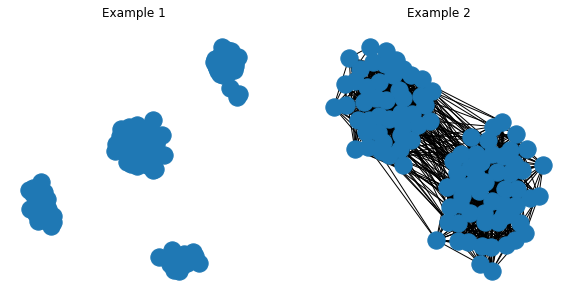

In [630]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
nx.draw(G_example1, ax=axs[0])
nx.draw(G_example2, ax=axs[1])
axs[0].set_title('Example 1'); axs[1].set_title('Example 2');

# The algorithm
![image.png](imgs/algorithm.png)

## 1. Form the affinity matrix

In the article, Andrew Ng are using a set if points in some geometric space. We are using a graph, so we believe the affinity matrix is the adjacency matrix.

Again, read in the data and store it in a Pandas DataFrame.

In [631]:
df = pd.read_csv(test)
df['weight'] = 1
df

,from,to,weight
0,1,2,1
1,1,3,1
2,2,1,1
3,2,3,1
4,2,4,1
5,3,1,1
6,3,2,1
7,4,2,1
8,4,5,1
9,4,6,1


Get the adjacency matrix.

In [632]:
G = nx.from_pandas_edgelist(df=df, source='from', target='to', edge_attr=['weight'])
A = nx.to_numpy_matrix(G)
pd.DataFrame(A, dtype=int)

,0,1,2,3,4,5
0,0,1,1,0,0,0
1,1,0,1,1,0,0
2,1,1,0,0,0,0
3,0,1,0,0,1,1
4,0,0,0,1,0,1
5,0,0,0,1,1,0


# 2. Construct the normalized Laplacian

First we find the eigenvalues and eigenvectors of the adjacency matrix. Since it is symmetric, we use the python library `eigh`.

In [633]:
eigvals, eigvecs = LA.eigh(A)

We then construct the diagonal matrix `D` from the affinity matrix `A`, where `D[i,i] = sum(A[i,:])`.

In [634]:
D = np.zeros((len(A), len(A)))
for i in range(D.shape[0]):
    D[i,i] = A.sum(axis=1)[i]

pd.DataFrame(D)

,0,1,2,3,4,5
0,2.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0


And now we form the Laplacian.

In [635]:
#L = ((sqrtm(inv(D))).dot(A)).dot(sqrtm(inv(D)))
L = D - A
pd.DataFrame(L)

,0,1,2,3,4,5
0,2.0,-1.0,-1.0,0.0,0.0,0.0
1,-1.0,3.0,-1.0,-1.0,0.0,0.0
2,-1.0,-1.0,2.0,0.0,0.0,0.0
3,0.0,-1.0,0.0,3.0,-1.0,-1.0
4,0.0,0.0,0.0,-1.0,2.0,-1.0
5,0.0,0.0,0.0,-1.0,-1.0,2.0


Find the eignvalues and eigenvectors of the normalized Laplacian `L`.

> **From the article:** normalize rows to have unit length

In [636]:
eigvals, eigvecs = LA.eigh(L)
print(pd.DataFrame(eigvals))
print(pd.DataFrame(eigvecs))

              0
0 -7.077672e-16
1  4.384472e-01
2  3.000000e+00
3  3.000000e+00
4  3.000000e+00
5  4.561553e+00
          0         1         2         3         4         5
0 -0.408248  0.464705  0.660891  0.344680 -0.166590  0.184524
1 -0.408248  0.260956 -0.374851  0.023266 -0.438496 -0.657192
2 -0.408248  0.464705 -0.286040 -0.367947  0.605086  0.184524
3 -0.408248 -0.260956 -0.374851  0.023266 -0.438496  0.657192
4 -0.408248 -0.464705 -0.067645  0.598472  0.469669 -0.184524
5 -0.408248 -0.464705  0.442496 -0.621739 -0.031173 -0.184524


The eigenvectors are already sorted and normalized as per the Numpy implementation, so we can just take the first `k` of them.

In [637]:
k = 2
Y = eigvecs[:,0:k]
pd.DataFrame(Y)

,0,1
0,-0.408248,0.464705
1,-0.408248,0.260956
2,-0.408248,0.464705
3,-0.408248,-0.260956
4,-0.408248,-0.464705
5,-0.408248,-0.464705


In [638]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k).fit(np.asarray(Y))

clusters = kmeans.labels_

Now, proceed with the assigning the original points (in our case, rows in the affinity matrix) to the clusters.

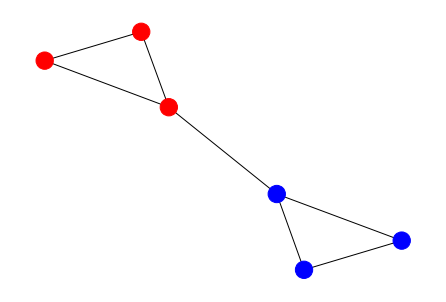

In [639]:
colors = {0: 'red', 1: 'blue'}
nx.draw(G, node_color=[colors[cluster] for cluster in clusters])

# `SpectralClustering` class

In [646]:
class SpectralClustering:
    def __init__(self, G, k=5):
        """
        Adjecency list is a networkx graph
        """
        self.G = G
        self.k = k
        self.clusters = None
        self.fiedler_vector = None

    def fit(self, adjecency_list):
        """
        This method runs the spectral clustering algorithm
        Instead of normalizing the laplacian, we use L = D - A
        """
        # step 1
        self.A = nx.to_numpy_matrix(adjecency_list)
        # step 2    
        D = self.diy_diagonalize(self.A)
        L = ((sqrtm(inv(D))).dot(self.A)).dot(sqrtm(inv(D)))
        #L = D - self.A
        self.L = L
        # step 3
        eigvals, eigvecs = LA.eigh(L)
        # step 4
        # NOTE the eigenvectors are already normalized
        # step 5
        Y = eigvecs[:,:k]
        kmeans = KMeans(n_clusters=self.k, random_state=0).fit(np.asarray(Y))
        self.clusters = kmeans.labels_
        self.fiedler_vector = self.set_fiedler_vector()
        # half step 6

    def normalize(self, matrix):
        """
        This method normalizes a matrix
        """
        return matrix / np.linalg.norm(matrix, axis=1)

    def diy_diagonalize(self, matrix):
        """
        I have the wrong np version so I can't use np.diag
        """
        D = np.zeros((len(self.A), len(self.A)))
        for i in range(D.shape[0]):
            D[i,i] = self.A.sum(axis=1)[i]
        return D

    def set_fiedler_vector(self):
        """
        This method sets the fiedler vector
        """
        # degree matrix
        D = self.diy_diagonalize(self.A)
        #L = ((sqrtm(inv(D))).dot(self.A)).dot(sqrtm(inv(D)))
        L = D-self.A
        eigvals, eigvecs = LA.eigh(L)
        self.eigvecs = eigvecs
        return eigvecs[:,1]

    def number_of_components(self, threshold = 1e-10):
        """
        [From wiki] The number of times 0 appears as an eigenvalue in the Laplacian is the number of connected components in the graph
        """
        eigvals, _ = LA.eigh(self.L)
        return len([eigval for eigval in eigvals if eigval < threshold])

    def plot_fiedler_vector(self):
        """
        This method plots the fiedler vector
        """
        plt.plot(np.sort(self.fiedler_vector))
        plt.show()
    
    def plot(self):
        colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'purple', 5: 'gray', 6: 'yellow', 7: 'pink', 8: 'black', 9: 'brown', 10: 'cyan'}
        nx.draw(self.G, node_color=[colors[cluster] for cluster in self.clusters])
        plt.show()

## Example 1

Let's see if the class works with the data we have been provided.

In [641]:
example1 = './data/example1.dat'

# requires us to append a weight column
df = pd.read_csv(example1)
df['weight'] = 1

print("Number of unique nodes: ", df['from'].nunique())

Number of unique nodes:  241


[3 1 0 2 3 0 0 0 0 0 0 0 0 0 1 1 2 0 0 0 2 0 1 3 0 0 0 0 2 2 0 0 0 0 2 2 0
 1 2 0 0 1 0 0 0 1 0 1 2 2 2 2 2 0 0 1 0 3 1 2 0 2 1 1 0 0 0 0 0 0 0 2 0 0
 2 1 0 3 0 0 0 2 0 0 2 2 2 1 1 2 1 2 2 0 0 0 2 0 1 1 0 0 0 1 1 1 0 0 0 1 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


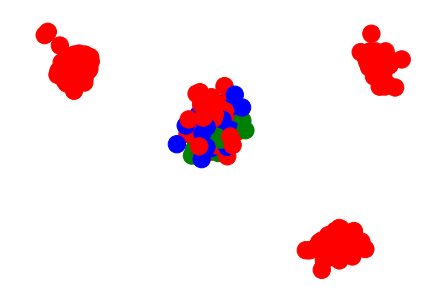

Number of components:  132


In [642]:
# set up the graph
G = nx.from_pandas_edgelist(df=df, source='from', target='to', edge_attr=['weight'])

# make a new spectral clustering object and fit the graph
sc = SpectralClustering(G=G, k=4)
sc.fit(G)

# plot and print the number of components
sc.plot()
print("Number of components: ", sc.number_of_components())

## Example 2

In [643]:
example2 = './data/example2.dat'
df = pd.read_csv(example2)

print("Number of unique nodes: ", df['from'].nunique())

Number of unique nodes:  100


[0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0
 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0]


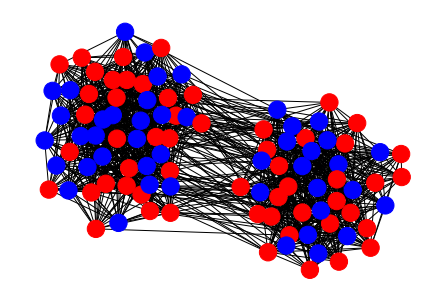

Number of components:  53


In [644]:
# set up the graph
G = nx.from_pandas_edgelist(df=df, source='from', target='to', edge_attr=['weight'])

# make a new spectral clustering object and fit the graph
sc = SpectralClustering(G=G, k=2)
sc.fit(G)

# plot and print the number of components
sc.plot()
print("Number of components: ", sc.number_of_components())

In [645]:
# create a numpy 3x3 matrix 
A = np.random.randint(10, size=9).reshape(3,3)

a, b = LA.eigh(A)

# assert that the length of each row is 1
np.linalg.norm(b, axis=0)


array([1., 1., 1.])